In [1]:
import numpy as np
# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from gurobipy import *
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
import collections
import cvxpy as cp

## Estimation Models

In [38]:
## linear regression
def linear_regress(Xs, Rs, reg):
    X_train, R_train = [], []
    for j in range(J):
        tmp = np.concatenate((Xs[j], np.zeros((len(Xs[j]), (d+1) * (J-1)))), axis=1)
        if j >= 1:
            for n in range(len(Rs[j])):
                tmp[n][d + (j-1) * (d+1)] = 1
                tmp[n][d + (j-1) * (d+1) + 1: d + j * (d+1)] = Xs[j][n]
        
        X_train.append(tmp)
        R_train.append(Rs[j])
    
    X_trains = np.concatenate(X_train)
    R_trains = np.concatenate(R_train)
    
    if reg == 'ordinal':
        lr, cv_loss = ols(X_train, R_train)
        return lr.intercept_, lr.coef_, cv_loss
    elif reg == 'ridge':
        m = linear_model.RidgeCV(cv=10)
        lr = m.fit(X_trains, R_trains)
    elif reg == 'lasso':
        m = linear_model.LassoCV(cv=10)
        lr = m.fit(X_trains, R_trains)  
    elif reg == 'new':
        res, cv_loss = new(X_train, R_train)
        
        return res[0], res[1:], cv_loss
        
    return lr.intercept_, lr.coef_

In [201]:
def new(X_train, R_train): 
    F = 10
    p = (0, 0.5, 0.5)
    
    X_train_0 = np.concatenate((np.reshape(np.ones(len(X_train[0])), (-1, 1)), X_train[0]), axis=1)
    X_train_1 = np.concatenate((np.reshape(np.ones(len(X_train[1])), (-1, 1)), X_train[1]), axis=1)
    X_train_2 = np.concatenate((np.reshape(np.ones(len(X_train[2])), (-1, 1)), X_train[2]), axis=1)
    
    X_fold = {0: np.split(X_train_0, 10), 1: np.split(X_train_1, 10), 2: np.split(X_train_2, 10)}
    R_fold = {0: np.split(R_train[0], 10), 1: np.split(R_train[1], 10), 2: np.split(R_train[2], 10)}
    
    coefs = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 10, 20]
#     coefs = [0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 30]
    coefs_loss = []
    for coef in coefs:  
        Loss = 0
        for k in range(F):
            R_valid = np.concatenate([R_fold[j][k] for j in range(J)])
            X_valid = np.concatenate([X_fold[j][k] for j in range(J)])

            R_input = np.concatenate([R_fold[j][l] for j in range(J) for l in range(F) if l != k])
            X_input = np.concatenate([X_fold[j][l] for j in range(J) for l in range(F) if l != k])

            beta = solve_convex(X_input, R_input, coef, p)

            loss = np.sum((np.dot(X_valid, beta) - R_valid) ** 2)
            Loss += loss
        coefs_loss.append(Loss / (J * N))
    
    cv_coef = coefs[np.argmin(coefs_loss)]
    cv_loss = np.min(coefs_loss) 
    print(cv_coef)
    print(cv_loss)
    beta = solve_convex(np.concatenate([X_train_0, X_train_1, X_train_2]), np.concatenate(R_train), cv_coef, p)

    return beta, coefs_loss

In [4]:
def ols(X_train, R_train): 
    F = 10
    X_fold = {0: np.split(X_train[0], F), 1: np.split(X_train[1], F), 2: np.split(X_train[2], F)}
    R_fold = {0: np.split(R_train[0], F), 1: np.split(R_train[1], F), 2: np.split(R_train[2], F)}

    Loss = 0
    for k in range(F):
        R_valid = np.concatenate([R_fold[j][k] for j in range(J)])
        X_valid = np.concatenate([X_fold[j][k] for j in range(J)])

        R_input = np.concatenate([R_fold[j][l] for j in range(J) for l in range(F) if l != k])
        X_input = np.concatenate([X_fold[j][l] for j in range(J) for l in range(F) if l != k])

        lr = linear_model.LinearRegression().fit(X_input, R_input) 
        loss = np.sum((lr.intercept_ + np.dot(X_valid, lr.coef_) - R_valid) ** 2)
        Loss += loss
    
    m = linear_model.LinearRegression()
    lr = m.fit(np.concatenate(X_train), np.concatenate(R_train))
    cv_loss = Loss / (J * N)
    print(cv_loss)
    return lr, cv_loss

In [5]:
def solve_convex(X_input, R_input, _lambda, _prob):
    beta = cp.Variable((d + 1) * J)
    loss = cp.sum_squares(X_input @ beta - R_input) / len(R_input)
    
    regularizer = 0
    for j in range(J):
#         if j >= 1:
#             for i in range(d):
#                 regularizer += (sigma[i] * (beta[i+1+j*(d+1)])) ** 2 * _prob[j]        
        
        if j >= 1:
            regularizer += cp.quad_form(beta[1+j*(d+1):(j+1)*(d+1)], Sigma) * _prob[j]    
    
#         if j == 0:
#             for i in range(d):
#                 regularizer += (sigma[i] * beta[i+1]) ** 2 * _prob[j]
#         elif j >= 1:
#             for i in range(d):
#                 regularizer += (sigma[i] * (beta[i+1] + beta[i+1+j*(d+1)])) ** 2 * _prob[j]
        
#         if j == 0:
#             regularizer += cp.quad_form(beta[1:d+1], Sigma) * _prob[j]
#         else:
#             regularizer += cp.quad_form(beta[1:d+1] + beta[1+j*(d+1):(j+1)*(d+1)], Sigma) * _prob[j]
           
                
    prob = cp.Problem(cp.Minimize(loss + regularizer * _lambda))
    prob.solve()
    
    return beta.value

## Optimization Models

In [6]:
def inner_opt_soc(Z, Gamma, gamma):
    m = Model()
    m.setParam('LogToConsole', 0)
    
    Beta_0 = m.addVars((j for j in range(J)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    Beta_1 = m.addVars(((j, i) for j in range(J) for i in range(d)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    Delta = m.addVars(((j, n) for j in range(J) for n in range(len(Xs[j]))), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    
    m.setObjective(sum([Z[j, k] * (Beta_0[j] + sum(Beta_1[j, i] * XC[k, i] for i in range(d))) for j in range(J) for k in range(K)]), GRB.MINIMIZE)
    
    for j in range(J):
        m.addConstr(Beta_0[j] + sum([Beta_1[j, i] * mu[i] for i in range(d)]) >= marginal_estimation[j])
        
    for j in range(J):
        for n in range(len(Xs[j])):
            m.addConstr(Delta[j, n] == Beta_0[j] + sum([Beta_1[j, i] * Xs[j][n, i] for i in range(d)]) - Rs[j][n])
    
    m.addConstr(sum([Delta[j, n] ** 2 for j in range(J) for n in range(len(Xs[j]))]) <= Gamma ** 2)
    
    for j in range(J):
        m.addConstr(sum([(Beta_1[j, i] * X_std[i]) ** 2 for i in range(d)]) <= gamma[j] ** 2)
        
    m.optimize()
    sol = m.getAttr('X', Beta_1)
    print(sol)

In [7]:
def robust_opt_soc(X_new, Gamma, gamma):
    m = Model()
    m.setParam('LogToConsole', 0)
    m.setParam('BarHomogeneous', 1)
    m.setParam('Method', 2)
    m.setParam('MIPGap', 0.01)
    
    Z = m.addVars(((j, k) for k in range(K) for j in range(J)), vtype=GRB.BINARY, lb=0, ub=1)
    Lambda = m.addVars((0,), vtype=GRB.CONTINUOUS, lb=0)
    Theta = m.addVars((j for j in range(J)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    Nu = m.addVars(((j, n) for j in range(J) for n in range(len(Xs[j]))), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    _lambda = m.addVars((j for j in range(J)), vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY)
    alpha = m.addVars(((j, i) for j in range(J) for i in range(d)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    
    marginal_gain = sum([Theta[j] * mean_estimation[j] for j in range(J)])
    estimate_gain = sum([Rs[j][n] * Nu[j, n] for j in range(J) for n in range(len(Xs[j]))])
    bias_loss = Gamma * Lambda[0]
    local_loss = sum([gamma[j] * _lambda[j] for j in range(J)])
    
    m.setObjective(marginal_gain + estimate_gain - bias_loss - local_loss, GRB.MAXIMIZE)
  
    ## part 0
    m.addConstr(sum(Theta[j] for j in range(J)) + sum([Nu[j, n] for j in range(J) for n in range(len(Xs[j]))]) == sum([Z[j, k] for j in range(J) for k in range(K)]))
    for j in range(1, J):
        m.addConstr(Theta[j] + sum([Nu[j, n] for n in range(len(Xs[j]))]) == sum([Z[j, k] for k in range(K)]))

    ## part 1
    for i in range(d):
        m.addConstr(sum(Theta[j] * mu[i] for j in range(J)) + sum(Nu[j, n] * Xs[j][n, i] for j in range(J) for n in range(len(Xs[j]))) + sum(alpha[j, i] * sigma[i] for j in range(J)) == sum([Z[j, k] * X_new[k][i] for j in range(J) for k in range(K)]))
        for j in range(1, J):
            m.addConstr(Theta[j] * mu[i] + sum(Nu[j, n] * Xs[j][n, i] for n in range(len(Xs[j]))) + alpha[j, i] * sigma[i] == sum([Z[j, k] * X_new[k][i] for k in range(K)]))

    ## part 2
    m.addConstr(sum([Nu[j, n] ** 2 for j in range(J) for n in range(len(Xs[j]))]) <= Lambda[0] ** 2)
    
    for j in range(J):
        m.addConstr(sum([alpha[j, i] ** 2 for i in range(d)]) <= _lambda[j] ** 2)
        
    m.addConstr(Lambda[0] <= 1000)   
    for j in range(J):
        m.addConstr(_lambda[j] <= 1000)   
        
    for k in range(K):
        m.addConstr(sum([Z[j, k] for j in range(J)]) == 1)
        
#     m.addConstr(sum(Z[1, k] for k in range(K)) <= 0.3 * K)
#     m.addConstr(sum(Z[2, k] for k in range(K)) <= 0.3 * K)
        

    m.addConstr(Lambda[0] == 0)

    m.optimize()
    
    policy = ['NA'] * K
    sol = m.getAttr('X', Z)
    obj = m.objVal
    for j, k in sol:
        if sol[j, k] > 0.9:
             policy[k] = j
    
    return policy, obj

In [8]:
def det_opt(Phi):
    m = Model()
    m.setParam('LogToConsole', 0)
    m.setParam('BarHomogeneous', 1)
    m.setParam('Method', 2)
    
    Z = m.addVars(((j, k) for k in range(K) for j in range(J)), vtype=GRB.BINARY, lb=0, ub=1)
  
    m.setObjective(sum([Z[j, k] * Phi[j, k] for j in range(J) for k in range(K)]), GRB.MAXIMIZE)
  
    for k in range(K):
        m.addConstr(sum([Z[j, k] for j in range(J)]) == 1)
   
    m.optimize()
    
    policy = ['NA'] * K
    sol = m.getAttr('X', Z)
    obj = m.objVal
    for j, k in sol:
        if sol[j, k] > 0.9:
             policy[k] = j
    
    return policy, obj

In [9]:
J = 3
d = 20
p = [1 / J] * J

In [216]:
# generate coefficients
def generate_model():
    np.random.seed(5)
    beta_share_0 = np.random.normal(0.3, 0)
    beta_share_1 = np.random.normal(0, 0.2, size=d)

    beta_0 = np.random.normal(0, 0.1, size=J-1)
    beta_1 = np.random.normal(0, 0.05, size=(J-1, d))
    
    return beta_share_0, beta_share_1, beta_0, beta_1

In [158]:
# generate data
def generate_samples(N, seed):
    np.random.seed(seed)
#     X_mean = np.random.uniform(0.2, 0.8, size=d)
    
    Xs = []
    Rs = []
    for j in range(J):
#         X = np.random.binomial(n=1, p=X_mean, size=(int(p[j] * N), d))
        X = np.random.normal(0, 1, size=(int(p[j] * N), d))
        R = []
        for X_n in X:
            R_share = beta_share_0 + np.dot(X_n, beta_share_1)
            R_noise = np.random.normal(0, 0.5)
            if j == 0:
                R_treat = 0
            else:
                R_treat = beta_0[j-1] + np.dot(X_n, beta_1[j-1]) 

            R_n = R_share + R_noise + R_treat    
            R.append(R_n)

        Xs.append(X)
        Rs.append(R)
        
    Xv = []
    Rv = []

    for j in range(J):
#         X = np.random.binomial(n=1, p=X_mean, size=(int(p[j] * N), d))
        X = np.random.normal(0, 1, size=(int(p[j] * N), d))
        R = []
        for X_n in X:
            R_share = beta_share_0 + np.dot(X_n, beta_share_1)
            R_noise = np.random.normal(0, 0.5)
            if j == 0:
                R_treat = 0
            else:
                R_treat = beta_0[j-1] + np.dot(X_n, beta_1[j-1]) 

            R_n = R_share + R_noise + R_treat    
            R.append(R_n)

        Xv.append(X)
        Rv.append(R)
        
    mu = np.mean(np.concatenate(Xs), 0)
        
    sigma = np.array([np.std(np.concatenate(Xs)[:,i]) for i in range(d)])
    Sigma = np.cov(np.concatenate(Xs).T)
    
    return Xs, np.array(Rs), Xv, np.array(Rv), mu, sigma, Sigma

In [159]:
def generate_candidates():
    np.random.seed(1000)
    
#     Xc = np.random.binomial(n=1, p=X_mean, size=(K, d))
    Xc = np.random.normal(0, 1, size=(K, d))
    Rc = []
    for X_n in Xc:
        Rc_n = []
        R_share = beta_share_0 + np.dot(X_n, beta_share_1)
        R_noise = np.random.normal(0, 0.5)
        for j in range(J):
            if j == 0:
                R_treat = 0
            else:
                R_treat = beta_0[j-1] + np.dot(X_n, beta_1[j-1]) 
            R_n = R_share + R_noise + R_treat
            Rc_n.append(R_n)
        Rc.append(Rc_n)
        
    return Xc, Rc

In [160]:
## moment information
def estimate_moments():
    mean_estimation = []
    for j in range(J):
        if j == 0:
            ave_effect = hat_beta_share_0 + np.dot(mu, hat_beta_share_1) 
        if j >= 1:
            ave_effect = hat_beta_share_0 + hat_beta_0[j-1] + np.dot(mu, (hat_beta_share_1 + hat_beta_1[j-1])) 
        
        mean_estimation.append(ave_effect)
        
    variance_estimation = []
    for j in range(J):
        var = 0
        for i in range(d):
            if j == 0:
                tmp = hat_beta_share_1[i] * sigma[i]
            if j >= 1:
                tmp = (hat_beta_share_1[i] + hat_beta_1[j-1][i]) * sigma[i]
            var += (tmp ** 2)
        variance_estimation.append(np.sqrt(var))

    variance_estimation = np.array(variance_estimation)
    
    return mean_estimation, variance_estimation

In [1]:
## training
def prediction(reg):
    hat_beta_share_0, params, coefs_loss = linear_regress(Xs, Rs, reg)
    hat_beta_0, hat_beta_1 = [], []
    hat_beta_share_1 = params[:d]

    for j in range(1, J):
        hat_beta_0.append(params[d + (j-1) * (d+1)])
        hat_beta_1.append(params[d + (j-1) * (d+1) + 1: d + j * (d+1)])

#     hat_Rs = []
#     for j in range(J):
#         hat_R = []
#         for n in range(len(Xs[j])):
#             hat_R_n = hat_beta_share_0 + np.dot(Xs[j][n], hat_beta_share_1)   
#             if j >= 1:
#                 hat_R_n += (hat_beta_0[j-1] + np.dot(Xs[j][n], hat_beta_1[j-1]))
#             hat_R.append(hat_R_n)
#         hat_Rs.append(hat_R)

#     loss = metrics.mean_squared_error(Rs, hat_Rs) 

    return hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, coefs_loss

In [162]:
## testing
def prescription():
    gamma = variance_estimation
    Gamma = np.sqrt(loss * r)

    stats = []
    policy_dis = [collections.defaultdict(int), collections.defaultdict(int)]
    for b in range(1):
        Xc, Rc = generate_candidates()
        
        if r > 1:
            policy_robust, obj = robust(Xc, Gamma, gamma)
            if obj >= 3000:
                print('error')
        policy_lr, obj = greedy(Xc)
        policy_optimal, obj = optimal(Xc)

        rewards_robust, rewards_lr, rewards_opt = 0, 0, 0
        for k in range(K):
            if r > 1:
                W_k = policy_robust[k]
                policy_dis[0][W_k] += 1
                rewards_robust += Rc[k][W_k]

            W_k = policy_lr[k]
            policy_dis[1][W_k] += 1
            rewards_lr += Rc[k][W_k]
            
            W_k = policy_optimal[k]
            rewards_opt += Rc[k][W_k]

        stats.append([rewards_robust, rewards_lr, rewards_opt])
        
    return stats, policy_dis

In [163]:
# marginal_estimation = {}
# for j in range(J):
#     boot_strap = []
#     for _ in range(1000):
#         boot_strap.append(np.mean(np.random.choice(Rs[j], size=len(Rs[j]), replace=True)))
#     ave_effect_lower = sorted(boot_strap)[100]
#     marginal_estimation[j] = ave_effect_lower

## Some Benchmarks

In [164]:
def greedy(Xc):
    Phi = {}
    for k in range(K):
        for j in range(J):
            Yc_pred = hat_beta_share_0 + np.dot(Xc[k], hat_beta_share_1)
            if j >= 1:
                Yc_pred += (hat_beta_0[j-1] + np.dot(Xc[k], hat_beta_1[j-1]))
            Phi[j, k] = Yc_pred

    policy_lr, obj = det_opt(Phi)
                
    return policy_lr, obj

def optimal(Xc):      
    Phi = {}
    for k in range(K):
        for j in range(J):
            Yc_pred = beta_share_0 + np.dot(Xc[k], beta_share_1)
            if j >= 1:
                Yc_pred += (beta_0[j-1] + np.dot(Xc[k], beta_1[j-1]))
            Phi[j, k] = Yc_pred

    policy_opt, obj = det_opt(Phi)
   
    return policy_opt, obj


def robust(Xc, Gamma, gamma):
    #policy_robust, sol = robust_opt(Gamma)
    policy_robust, obj = robust_opt_soc(Xc, Gamma, gamma)
    
    return policy_robust, obj

## Main

In [165]:
K = 1000

In [214]:
beta_share_0, beta_share_1, beta_0, beta_1 = generate_model()

output = {}
for N in [600]:
    for reg in ['new']:
        performance, predict_loss = [], []
        for seed in range(5):
            print('Estimation: ' + str(reg) + ', Number of samples per treatment: ' + str(N) + ', Seed: ' + str(seed))
            Xs, Rs, Xv, Rv, mu, sigma, Sigma = generate_samples(N, seed)
            hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, coefs_loss = prediction(reg)
            mean_estimation, variance_estimation = estimate_moments()
            
            if reg == 'ordinal':
                r = 1
            else:
                r = 1
            stats, policy_dis = prescription()
            
            res = np.mean(stats, axis=0) / K
            print(res)
            performance.append([res[0], res[1], max(res[0], res[1])])
            predict_loss.append(coefs_loss)

        output[N, reg] = performance

Estimation: new, Number of samples per treatment: 600, Seed: 0
0
0.1009685101820583
[0.         1.9977598  2.01102591]
Estimation: new, Number of samples per treatment: 600, Seed: 1
0
0.09789083785154967
[0.         2.00467224 2.01102591]
Estimation: new, Number of samples per treatment: 600, Seed: 2
0
0.08922091448607888
[0.         2.00117622 2.01102591]
Estimation: new, Number of samples per treatment: 600, Seed: 3
0
0.09130191924485316
[0.         2.00473482 2.01102591]
Estimation: new, Number of samples per treatment: 600, Seed: 4
0
0.09403793444910213
[0.         2.00409144 2.01102591]


In [192]:
for reg in ['ordinal']:
    ave, std = [], []
    for N in [300]:
        ave.append(np.round(np.mean(output[N, reg], axis=0), 3))
        std.append(np.round(np.std(output[N, reg], axis=0), 3))
    
    print(ave)
    print(std)
    print('---------')

[array([0.   , 0.358, 0.358])]
[array([0.   , 0.015, 0.015])]
---------


In [193]:
np.mean(predict_loss)

0.12585374842795244

In [143]:
policy_dis

[defaultdict(int, {}), defaultdict(int, {1: 392, 2: 198, 0: 410})]

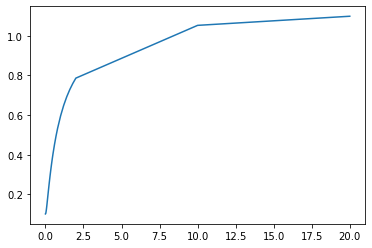

In [215]:
x = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 10, 20]
y = predict_loss[0]
plt.plot(x, y)

In [200]:
np.std(Rs, axis=1)

array([1.29780531, 1.21832063, 1.08291991])

In [204]:
beta_0, beta_1

(array([-0.06315716, -0.00061949]),
 array([[-0.00505338, -0.00261541,  0.01246088,  0.009883  ,  0.06674243,
         -0.00434378,  0.07807661, -0.01529265, -0.02388657,  0.00503691,
          0.01777192,  0.01348062,  0.06459817,  0.05696715,  0.02472202,
         -0.01681681, -0.00503072,  0.0706699 ,  0.01106271, -0.06553866,
         -0.03447826, -0.02887566,  0.05761024, -0.0053582 ,  0.11300534,
          0.03283097,  0.00624034, -0.0217852 ,  0.04860897, -0.01203556],
        [-0.04120617,  0.02840664,  0.00063792,  0.05945304, -0.00367967,
         -0.1429844 ,  0.03946832, -0.09388704,  0.07693781,  0.09106824,
         -0.02135157, -0.0582351 , -0.0698537 ,  0.04363273, -0.01010591,
         -0.029918  , -0.01217099,  0.10442573,  0.01734597,  0.03728635,
          0.03884538,  0.05092106,  0.05306757, -0.03552332, -0.01075939,
         -0.03803802, -0.03555816,  0.05707539, -0.02508778, -0.00395757]]))

In [205]:
beta_share_0, beta_share_1

(0.3,
 array([-0.06617403,  0.48615424, -0.05041843,  0.02192197,  0.31649622,
        -0.18184648, -0.11832733,  0.03752065, -0.06597399, -0.23855292,
        -0.0409753 , -0.07176579,  0.12069432, -0.33295771, -0.14003581,
         0.2302782 ,  0.3714662 , -0.30223591,  0.1289695 , -0.19612158,
        -0.17137063, -0.17437584, -0.08450159,  0.19928797,  0.14248425,
         0.01182885, -0.07266218,  0.00065777, -0.02118609,  0.15861066]))

In [207]:
np.sum(beta_1[0] ** 2)

0.052170986060615335

In [212]:
np.std(np.dot(Xs[1], beta_1[0]))

0.2348482343696064

In [210]:
np.std(np.dot(Xs[0], beta_share_1))

1.0268992462603563